# Writing High-Frequency Trajectories When an Event is Detected

In this tutorial, we will showcase how Dupin's online capabilities can be used to
trigger HOOMD's burst writer to dump high-resolution trajectory data only during
specific events detected by Dupin. This approach has significant implications for
performance and storage. The main advantage is that it allows us to write to disk only
the segments of the trajectory that are of interest, at an extremely high frequency,
without dumping the entire trajectory.

To achieve this, we create a temporary buffer that stores trajectory frames in memory.
When Dupin triggers, this buffer is dumped onto the disk. Online detection requires some
CPU cycles to run periodically, which can impact performance of the MD program depending
on the order parameters used for detection. In practice, it is often sufficient to track
very simple properties that are computed by the MD driver (in this case, HOOMD) anyway,
such as pressure, total system energy, or volume (depending on whether we are running
NVT/NVE or NPT ensembles).

The render function in the next (hidden) cell will render the snapshot at the detected
change point using fresnel. You can find the source code for this function on github.

Here, we provide an example. First we melt a simple cubic crystal of Lennard-Jones
particles:

In [1]:
import math

import io
import fresnel
import IPython
import PIL
import fresnel
import IPython
import numpy as np

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)


def render(snapshot):
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry_B = fresnel.geometry.Sphere(
        scene, N=np.sum(snapshot.particles.typeid == 1), radius=0.5
    )
    geometry_B.material = fresnel.material.Material(
        color=fresnel.color.linear([1 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry = fresnel.geometry.Sphere(
        scene, N=np.sum(snapshot.particles.typeid == 0), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]),
        roughness=5,
        metal=0,
        specular=0.95,
        spec_trans=0.95,
    )
    geometry.position[:] = snapshot.particles.position[
        snapshot.particles.typeid == 0, :
    ]
    geometry.outline_width = 0.04
    geometry_B.position[:] = snapshot.particles.position[
        snapshot.particles.typeid == 1, :
    ]
    geometry_B.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(
            direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi
        ),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2),
        look_at=(0, 0, 0),
        up=(0, 1, 0),
        height=L * 1.4 + 1,
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=500)


def render_movie(frames):
    a = render(frames[0])
    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB").convert(
        "P", palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f)
        im = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB")
        im_p = im.quantize(palette=im0)
        ims.append(im_p)
    blank = np.ones(shape=(im.height, im.width, 3), dtype=np.uint8) * 255
    im = PIL.Image.fromarray(blank, mode="RGB")
    im_p = im.quantize(palette=im0)
    ims.append(im_p)
    f = io.BytesIO()
    im0.save(f, "gif", save_all=True, append_images=ims, duration=1000, loop=0)
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))


initial lattice


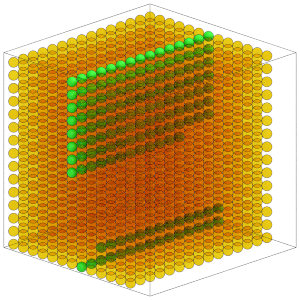

In [2]:

#%%
import itertools
import hoomd
import hoomd.md
import numpy as np
import math
import gsd
import gsd.hoomd

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.params[("A", "B")] = dict(epsilon=1, sigma=1)
lj.params[("B", "B")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5
lj.r_cut[("A", "B")] = 2.5
lj.r_cut[("B", "B")] = 2.5
integrator.forces.append(lj)

nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5),
)
integrator.methods.append(nvt)
#%%
#make initial system
m = 9
N_particles = 4 * m**3
spacing = 1.3
K = math.ceil(N_particles ** (1 / 3))
L = K * spacing
x = np.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
N_B = N_particles // 20

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]
frame.particles.types = ["A", "B"]
typeid = np.asarray(frame.particles.typeid)
typeid[frame.particles.N // 2 : frame.particles.N // 2 + N_B] = 1
frame.particles.typeid = typeid

with gsd.hoomd.open(name="lattice.gsd", mode="w") as f:
    f.append(frame)
print("initial lattice")
render(frame)

# Melt the crystal

First we melt the crystal to randomize the liquid configuration:

randomized configuration


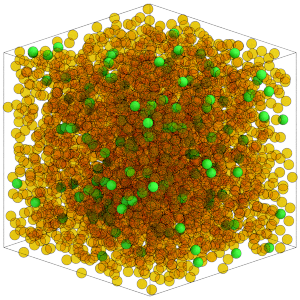

In [5]:
import hoomd

cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=667)
simulation.create_state_from_gsd(filename="lattice.gsd")
simulation.operations.integrator = integrator
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
simulation.operations.computes.append(thermodynamic_properties)
simulation.run(10000)
hoomd.write.GSD.write(state=simulation.state, filename="random.gsd", mode="wb")
print("randomized configuration")
render(simulation.state.get_snapshot())

# Compress the system

Next we compress the system to a denser state:

In [6]:
ramp = hoomd.variant.Ramp(A=0, B=1, t_start=simulation.timestep, t_ramp=20000)
steps = range(0, 40000, 20)
y = [ramp(step) for step in steps]
rho = simulation.state.N_particles / simulation.state.box.volume
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
final_rho = 0.8
final_box.volume = simulation.state.N_particles / final_rho
box_resize_trigger = hoomd.trigger.Periodic(10)
box_resize = hoomd.update.BoxResize(
    box1=initial_box, box2=final_box, variant=ramp, trigger=box_resize_trigger
)
simulation.operations.updaters.append(box_resize)
simulation.run(20001)
simulation.operations.updaters.remove(box_resize)

print("compressed configuration")
render(simulation.state.get_snapshot())
hoomd.write.GSD.write(
    state=simulation.state, filename="compressed.gsd", mode="wb"
)

/home/domi/mambaforge/envs/dupin/lib/python3.12/site-packages/hoomd/update/box_resize.py:147: FutureWarning: box1, box2, and variant are deprecated, use `box`
  warnings.warn('box1, box2, and variant are deprecated, use `box`',


compressed configuration


# Equilibrate the system

We equilibrate the liquid:

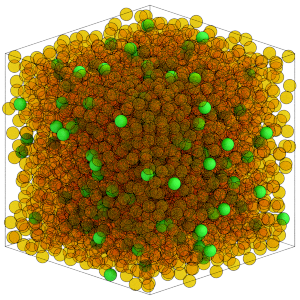

In [7]:
simulation.run(50000)
hoomd.write.GSD.write(
    state=simulation.state, filename="equilibrated.gsd", mode="wb"
)
render(simulation.state.get_snapshot())

# Burst writer

Finally, we run the compressed LJ system for 25000 steps then change the LJ potential of
particle type 2 to be much stronger and shorter ranged. This should initiate a
nucleation event of only part of the system. After 50000 steps we again change the LJ
potential of particle type 2 to be the same as interactions of particle type 1. To
detect these events we implement a custom Online Writer which dumps 400 frames spaced 10 time
steps apart each time dupin detects a transition. Each event will be written in a new
file starting with burst and ending with .gsd . We monitor potential energy to detect
possible events in this example. Keep in mind that this cell might take a while to run:

In [8]:
import ruptures as rpt

import dupin as du

gsd_writer = hoomd.write.GSD(
    filename="trajectory.gsd", trigger=hoomd.trigger.Periodic(1000), mode="wb"
)
log = hoomd.logging.Logger()
log.add(simulation, quantities=["timestep", "walltime"])
log.add(lj, quantities=["energy", "energies"])
log.add(thermodynamic_properties)
gsd_writer.logger = log

simulation.operations.writers.append(gsd_writer)


def custom_dupin_generator_fn(data_du):
    return {"energy": data_du}


custom_writer_trigger = hoomd.trigger.Periodic(1000)


class OnlineWriter(hoomd.custom.Action):
    def __init__(
        self,
        trigger,
        filename_base,
        max_burst_size,
        dupin_generator,
        potential,
        simulation: hoomd.Simulation,
        skip_first_N=0,
    ):
        self.dupin_event_times = []
        self.skip_first_N = skip_first_N
        self.counter = 0
        self.potential = potential
        self.trigger = trigger
        self.filename_base = filename_base
        self.max_burst_size = max_burst_size
        self.simulation = simulation
        self.burst_event_reporter = []
        self.make_new_burst()
        self.signal_aggregator = du.data.aggregate.SignalAggregator(
            du.data.base.CustomGenerator(dupin_generator).pipe(
                du.data.reduce.NthGreatest((-10, -50))
            )
        )
        self.transitioning = False
        self.transition_timestep = None
        self.sweep_detector = du.detect.SweepDetector(
            rpt.Dynp(custom_cost=du.detect.CostLinearFit()),
            max_change_points=6,
            tolerance=0.001,
        )
        self.burst_size_in_simulation_time = (
            self.max_burst_size * self.trigger.period
        )
        self.burst_size_in_signal_time = (
            self.burst_size_in_simulation_time / custom_writer_trigger.period
        )

    def act(self, timestep):
        data = self.potential.energies
        self.signal_aggregator.accumulate(data)
        if (
            self.counter > 0
            or self.skip_first_N
            < len(self.signal_aggregator.signals * custom_writer_trigger.period)
        ) and len(
            self.signal_aggregator.signals * custom_writer_trigger.period
        ) > self.burst_size_in_simulation_time:
            check = self.sweep_detector.fit(
                self.signal_aggregator.to_dataframe()
            )
            new_check = []
            for detected_online_event in check:
                if (
                    np.abs(
                        detected_online_event
                        - len(self.signal_aggregator.signals)
                    )
                    > self.burst_size_in_signal_time
                ):
                    continue
                isnew = True
                for event in self.dupin_event_times:
                    if (
                        np.abs(detected_online_event - event)
                        < self.burst_size_in_signal_time
                    ):
                        isnew = False
                        break
                if isnew:
                    new_check.append(detected_online_event)
            if len(new_check) > 0:
                self.dupin_event_times.append(new_check[-1])
                self.burst_event_reporter[-1][
                    "event_timesteps_simulation_time"
                ].append(timestep)
                self.burst_event_reporter[-1][
                    "event_timesteps_signal_time"
                ].append(new_check[-1])

                if self.transitioning:
                    self.transition_timestep = (
                        self.transition_timestep
                        + (
                            timestep
                            - (
                                len(self.signal_aggregator.signals)
                                - new_check[-1]
                            )
                            * custom_writer_trigger.period
                        )
                    ) / 2
                else:
                    self.transitioning = True
                    self.transition_timestep = (
                        timestep
                        - (len(self.signal_aggregator.signals) - new_check[-1])
                        * custom_writer_trigger.period
                    )

            if self.transitioning:
                buffer_end_when_centered_at_transition_timestep = (
                    self.transition_timestep
                    + self.burst_size_in_simulation_time * 0.5
                )
                if buffer_end_when_centered_at_transition_timestep <= timestep:
                    self.pop_burst(timestep)

    def pop_burst(self, timestep):
        self.burst_event_reporter[-1]["burst_end_timestep_simulation_time"] = (
            timestep
        )
        self.burst_event_reporter[-1]["burst_end_timestep_signal_time"] = len(
            self.signal_aggregator.signals
        )
        self.burst_event_reporter[-1][
            "burst_start_timestep_simulation_time"
        ] = timestep - self.burst_size_in_simulation_time
        self.burst_event_reporter[-1]["burst_start_timestep_signal_time"] = (
            len(self.signal_aggregator.signals) - self.burst_size_in_signal_time
        )
        self.burst_writer.dump()
        self.burst_writer.flush()
        self.simulation.operations.writers.remove(self.burst_writer)
        self.counter += 1
        self.make_new_burst()
        self.transitioning = False

    def make_new_burst(self):
        full_filename_base = self.filename_base + f"{self.counter}"
        full_filename = self.filename_base + f"{self.counter}.gsd"
        report = dict(
            name=full_filename_base,
            filename=full_filename,
            event_timesteps_simulation_time=[],
            event_timesteps_signal_time=[],
            burst_start_timestep_simulation_time=0,
            burst_end_timestep_simulation_time=0,
            burst_start_timestep_signal_time=0,
            burst_end_timestep_signal_time=0,
        )
        self.burst_event_reporter.append(report)
        log = hoomd.logging.Logger()
        log.add(self.simulation, quantities=["timestep", "walltime"])
        log.add(self.potential, quantities=["energy", "energies"])
        self.burst_writer = hoomd.write.Burst(
            trigger=self.trigger,
            filename=full_filename,
            max_burst_size=self.max_burst_size,
            write_at_start=True,
            mode="wb",
        )
        self.burst_writer.logger = log
        self.simulation.operations.writers.append(self.burst_writer)


dupin_online_writer = hoomd.write.CustomWriter(
    action=OnlineWriter(
        hoomd.trigger.Periodic(10),
        "burst",
        400,
        custom_dupin_generator_fn,
        lj,
        simulation,
    ),
    trigger=custom_writer_trigger,
)
simulation.operations += dupin_online_writer

simulation.run(25000)
## Apply the new potential
integrator.forces[-1].params[("B", "B")] = dict(epsilon=2.5, sigma=0.5)
simulation.run(100000)

# apply old potential
integrator.forces[-1].params[("B", "B")] = dict(epsilon=1, sigma=1)
simulation.run(25000)
gsd_writer.flush()
print("events detected by online burst writer")
print(dupin_online_writer.action.burst_event_reporter)

events detected by online burst writer
[{'name': 'burst0', 'filename': 'burst0.gsd', 'event_timesteps_simulation_time': [98000], 'event_timesteps_signal_time': [15], 'burst_start_timestep_simulation_time': 94000, 'burst_end_timestep_simulation_time': 98000, 'burst_start_timestep_signal_time': 14.0, 'burst_end_timestep_signal_time': 18}, {'name': 'burst1', 'filename': 'burst1.gsd', 'event_timesteps_simulation_time': [104000], 'event_timesteps_signal_time': [20], 'burst_start_timestep_simulation_time': 100000, 'burst_end_timestep_simulation_time': 104000, 'burst_start_timestep_signal_time': 20.0, 'burst_end_timestep_signal_time': 24}, {'name': 'burst2', 'filename': 'burst2.gsd', 'event_timesteps_simulation_time': [108000], 'event_timesteps_signal_time': [25], 'burst_start_timestep_simulation_time': 104000, 'burst_end_timestep_simulation_time': 108000, 'burst_start_timestep_signal_time': 24.0, 'burst_end_timestep_signal_time': 28}, {'name': 'burst3', 'filename': 'burst3.gsd', 'event_times

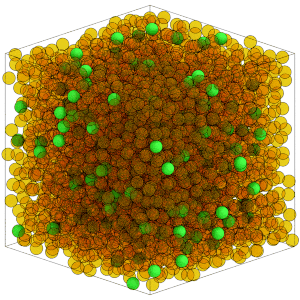

In [11]:
import gsd.hoomd

with gsd.hoomd.open("trajectory.gsd") as f:
    render_movie(f[::10])

# Detected events and burst coverage

In the following plot we show how the burst writer covered the following parts of the
trajectory based on the detected events:

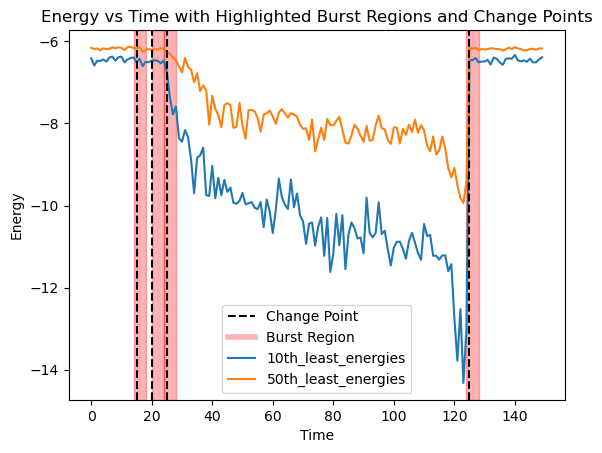

In [27]:
import gsd.hoomd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Example data structures
burst_ends = []
change_points = []
for trans in dupin_online_writer.action.burst_event_reporter[:-1]:
    burst_ends.append(
        (
            trans["burst_start_timestep_signal_time"],
            trans["burst_end_timestep_signal_time"],
        )
    )
    change_points.extend(trans["event_timesteps_signal_time"])


def custom_dupin_generator_fn(data_du):
    return {"energies": data_du}


pipeline = du.data.base.CustomGenerator(custom_dupin_generator_fn).pipe(
    du.data.reduce.NthGreatest((-10, -50))
)
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)

energy = []
with gsd.hoomd.open("trajectory.gsd") as f:
    for frame in f:
        energy.append(frame.log["particles/md/pair/LJ/energies"])
        signal_aggregator.accumulate(frame.log["particles/md/pair/LJ/energies"])

# Plot the data
data = signal_aggregator.to_dataframe().to_numpy()
lines = plt.plot(
    data,
    label=signal_aggregator.to_dataframe().columns.to_list(),
)

for change_point in change_points:
    plt.axvline(change_point, color="k", linestyle="--")

# Highlight burst regions
for burst_start, burst_end in burst_ends:
    plt.axvspan(
        burst_start, burst_end, color="red", alpha=0.3
    )

# Create custom legend handles

legend_elements = [
    Line2D([0], [0], color='k', linestyle='--', label='Change Point'),
    Line2D([0], [0], color='red', lw=4, alpha=0.3, label='Burst Region')
]
legend_elements.extend([line for line in lines])

plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy vs Time with Highlighted Burst Regions and Change Points")
plt.legend(handles=legend_elements)
plt.show()